Import all necessary libraries and install everything you need for training:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# install the libraries necessary for data wrangling, prediction and result analysis
import json
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score,precision_score, recall_score
import torch
from numba import cuda
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

In [4]:
# Install transformers
# (this needs to be done on Kaggle each time you start the session)
!pip install -q transformers

     |████████████████████████████████| 4.7 MB 30.6 MB/s 
     |████████████████████████████████| 6.6 MB 57.5 MB/s 
     |████████████████████████████████| 120 kB 74.7 MB/s 


In [5]:
# Install the simpletransformers
!pip install -q simpletransformers
from simpletransformers.classification import ClassificationModel

     |████████████████████████████████| 249 kB 31.4 MB/s 
     |████████████████████████████████| 43 kB 1.6 MB/s 
     |████████████████████████████████| 1.3 MB 62.2 MB/s 
     |████████████████████████████████| 9.1 MB 57.3 MB/s 
     |████████████████████████████████| 1.8 MB 39.7 MB/s 
     |████████████████████████████████| 365 kB 43.7 MB/s 
     |████████████████████████████████| 181 kB 50.0 MB/s 
     |████████████████████████████████| 157 kB 61.2 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 157 kB 12.9 MB/s 
     |████████████████████████████████| 157 kB 50.2 MB/s 
     |████████████████████████████████| 157 kB 49.2 MB/s 
     |████████████████████████████████| 157 kB 58.9 MB/s 
     |████████████████████████████████| 156 kB 17.5 MB/s 
     |████████████████████████████████| 115 kB 22.9 MB/s 
     |████████████████████████████████| 212 kB 50.0 MB/s 
     |████████████████████████████████| 127 kB 56.1 MB/s 
     |████████████

In [6]:
# Install wandb
!pip install -q wandb

In [7]:
import wandb

In [8]:
# Login to wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Clean the GPU cache

cuda.select_device(0)
cuda.close()
#cuda.select_device(0)
#torch.cuda.empty_cache()


### Import the data

In [9]:
# FTD
train_df = pd.read_csv("/content/drive/MyDrive/GitHub/Genre-Datasets-Comparison/data-splits/FTD-X-GENRE-train.txt", sep="\t", index_col=0)
dev_df = pd.read_csv("/content/drive/MyDrive/GitHub/Genre-Datasets-Comparison/data-splits/FTD-X-GENRE-dev.txt", sep = "\t", index_col = 0)
test_df = pd.read_csv("/content/drive/MyDrive/GitHub/Genre-Datasets-Comparison/data-splits/FTD-X-GENRE-test.txt", sep = "\t", index_col = 0)

print("FTD train shape: {}, Dev shape: {}, Test shape: {}.".format(train_df.shape, dev_df.shape, test_df.shape))

FTD train shape: (630, 2), Dev shape: (210, 2), Test shape: (210, 2).


In [10]:
train_df.head()

,text,labels
1244,Publications and Workbooks by TransforMED Tran...,Promotion
707,The Wastepack Group is the leading support ser...,Promotion
646,Victoria Reviews 2001 and Gives Us the Lowdown...,Opinion/Argumentation
1121,We noticed that you 're using an unsupported b...,Promotion
822,Fanny - First In A Long Time : The Reprise Rec...,Information/Explanation


In [11]:
dev_df

,text,labels
409,( 4 miles [ 7 km ] one way ) This walk follows...,Instruction
1051,1 . DISCLAIMER The content of this site is for...,Legal
1473,Achieve a 35-45 % improvement in the important...,Promotion
1432,Why Passport to Recovery In seeking immediate ...,Promotion
682,The business world provides many potential car...,Promotion
...,...,...
125,Tabs let you organize gadgets into groups Tabs...,Instruction
1437,RESEARCH DEVELOPMENT & RESULTS from Extensive ...,Promotion
453,N. 6 : A Protein Crystallographic Toolbox : CC...,News
690,High House is a small Victorian stone built co...,Promotion


In [12]:
test_df

,text,labels
439,Your search returned the following results . H...,Promotion
1576,Our Lotion is Back New Formulation Transfer Po...,Promotion
913,It mattered not that they made him sea-sick--h...,Prose/Lyrical
1514,This session is all about the HOW of telling a...,Promotion
1216,Fisherman's Friends deaths : Door company fine...,News
...,...,...
1510,The planar ferrite sheet-based antenna measure...,Promotion
247,Skills for Working Life What is the course abo...,Instruction
261,"News Item : 3 February , 2003 Citizenship to s...",Promotion
520,ho-me-refinancing.com How to Use a Mortgage Lo...,Instruction


## Testing

We will use the multilingual XLM-RoBERTa model
https://huggingface.co/xlm-roberta-base

In [29]:
# Open the main results file:

previous_results = pd.read_csv("/content/drive/MyDrive/GitHub/Genre-Datasets-Comparison/results/X-GENRE-Experiments-Results.csv", sep="\t", index_col = 0)

previous_results

,experiment,microF1,macroF1,y_true,y_pred,trained_on,tested_on
1,testing-FTD-X-GENRE-on-test,0.814286,0.827740,"{'409': 'Instruction', '1051': 'Legal', '1473'...","{'409': 'Information/Explanation', '1051': 'Le...",FTD,FTD
2,testing-FTD-X-GENRE-on-SL-GINCO-test,0.569832,0.498112,"{228: 'News', 12: 'Opinion/Argumentation', 617...","{228: 'Instruction', 12: 'Information/Explanat...",FTD,SL-GINCO
3,testing-FTD-X-GENRE-on-MT-GINCO-test,0.569832,0.457568,"{2: 'Promotion', 3: 'News', 12: 'Opinion/Argum...","{2: 'Promotion', 3: 'News', 12: 'Information/E...",FTD,MT-GINCO
4,testing-FTD-X-GENRE-on-CORE-test,0.477833,0.397299,"{216: 'Forum', 41678: 'Forum', 7171: 'News', 9...","{216: 'Opinion/Argumentation', 41678: 'Instruc...",FTD,CORE


In [30]:
previous_results.drop(index = 1, inplace= True)
previous_results

,experiment,microF1,macroF1,y_true,y_pred,trained_on,tested_on
2,testing-FTD-X-GENRE-on-SL-GINCO-test,0.569832,0.498112,"{228: 'News', 12: 'Opinion/Argumentation', 617...","{228: 'Instruction', 12: 'Information/Explanat...",FTD,SL-GINCO
3,testing-FTD-X-GENRE-on-MT-GINCO-test,0.569832,0.457568,"{2: 'Promotion', 3: 'News', 12: 'Opinion/Argum...","{2: 'Promotion', 3: 'News', 12: 'Information/E...",FTD,MT-GINCO
4,testing-FTD-X-GENRE-on-CORE-test,0.477833,0.397299,"{216: 'Forum', 41678: 'Forum', 7171: 'News', 9...","{216: 'Opinion/Argumentation', 41678: 'Instruc...",FTD,CORE


In [31]:
# reset index
previous_results.reset_index(inplace = True, drop = True)
previous_results

,experiment,microF1,macroF1,y_true,y_pred,trained_on,tested_on
0,testing-FTD-X-GENRE-on-SL-GINCO-test,0.569832,0.498112,"{228: 'News', 12: 'Opinion/Argumentation', 617...","{228: 'Instruction', 12: 'Information/Explanat...",FTD,SL-GINCO
1,testing-FTD-X-GENRE-on-MT-GINCO-test,0.569832,0.457568,"{2: 'Promotion', 3: 'News', 12: 'Opinion/Argum...","{2: 'Promotion', 3: 'News', 12: 'Information/E...",FTD,MT-GINCO
2,testing-FTD-X-GENRE-on-CORE-test,0.477833,0.397299,"{216: 'Forum', 41678: 'Forum', 7171: 'News', 9...","{216: 'Opinion/Argumentation', 41678: 'Instruc...",FTD,CORE


In [17]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [18]:
# Create a list of labels
LABELS = train_df.labels.unique().tolist()
LABELS

['Promotion',
 'Opinion/Argumentation',
 'Information/Explanation',
 'News',
 'Legal',
 'Instruction',
 'Prose/Lyrical']

In [19]:
# Initialize Wandb
run = wandb.init(project="X-GENRE classifiers", entity="tajak", name="testing-trained-model")

wandb: Currently logged in as: tajak. Use `wandb login --relogin` to force relogin


In [20]:
# Load the trained model from Wandb
model_name = "FTD-X-GENRE-classifier"
# Use the latest version of the model
model_at = run.use_artifact(model_name + ":latest")
# Download the directory
model_dir = model_at.download()

# Loading a local save
model = ClassificationModel(
    "xlmroberta", model_dir)

wandb: Downloading large artifact FTD-X-GENRE-classifier:latest, 1081.88MB. 44 files... Done. 0:0:24.6
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:476: UserWarning: use_multiprocessing automatically disabled as xlmroberta fails when using multiprocessing for feature conversion.
  f"use_multiprocessing automatically disabled as {model_type}"


In [21]:
def testing_FTD(test_df, test_name, tested_on):
    """
    This function takes the test dataset and applies the trained model on it to infer predictions.
    It also prints and saves a confusion matrix, calculates the F1 scores and saves the results in a list of results.

    Args:
    - test_df (pandas DataFrame)
    - test_name
    - tested_on : e.g. "CORE", "GINCO" etc.
    """
    # Get the true labels
    y_true = test_df.labels

    LABELS = test_df.labels.unique().tolist()

    # Calculate the model's predictions on test
    def make_prediction(input_string):
        return model.predict([input_string])[0][0]

    y_pred = test_df.text.apply(make_prediction)
    test_df["y_pred"] = y_pred

    # Calculate the scores
    macro = f1_score(y_true, y_pred, labels=LABELS, average="macro")
    micro = f1_score(y_true, y_pred, labels=LABELS,  average="micro")
    print(f"Macro f1: {macro:0.3}, Micro f1: {micro:0.3}")

    # Plot the confusion matrix:
    cm = confusion_matrix(y_true, y_pred, labels=LABELS)
    plt.figure(figsize=(9, 9))
    plt.imshow(cm, cmap="Oranges")
    for (i, j), z in np.ndenumerate(cm):
        plt.text(j, i, '{:d}'.format(z), ha='center', va='center')
    classNames = LABELS
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=90)
    plt.yticks(tick_marks, classNames)
    plt.title(f"{test_name}")

    plt.tight_layout()
    fig1 = plt.gcf()
    plt.show()
    plt.draw()
    fig1.savefig(f"/content/drive/MyDrive/GitHub/Genre-Datasets-Comparison/results/Confusion-matrix-{test_name}.png",dpi=100)

    # Append Row to DataFrame
    list_row = [test_name, micro, macro, y_true.to_dict(), y_pred.to_dict(), "FTD", tested_on]
    previous_results.loc[len(previous_results)] = list_row

    # Save the new dataframe which contains the y_pred values as well
    test_df.to_csv(f"/content/drive/MyDrive/GitHub/Genre-Datasets-Comparison/results/{test_name}-sheet-with-predictions.csv", sep="\t")

Macro f1: 0.828, Micro f1: 0.814


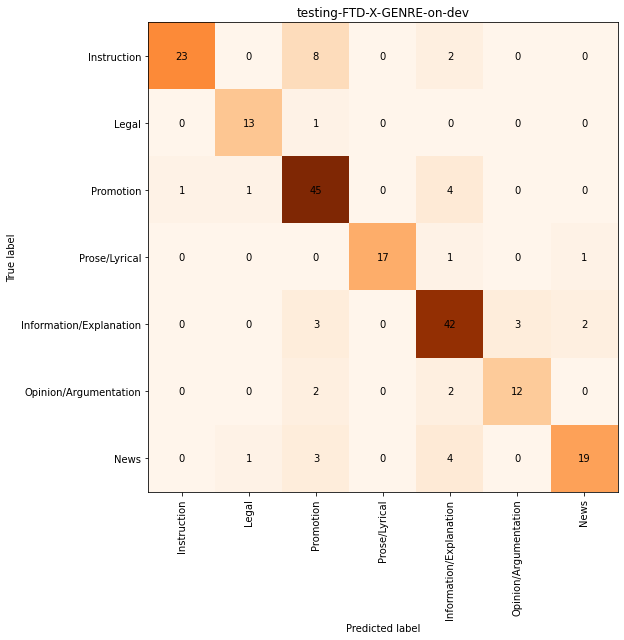


Testing finished.


<Figure size 432x288 with 0 Axes>

In [32]:
testing_FTD(dev_df, "testing-FTD-X-GENRE-on-dev", "FTD-dev")

print("\nTesting finished.")

In [33]:
previous_results

,experiment,microF1,macroF1,y_true,y_pred,trained_on,tested_on
0,testing-FTD-X-GENRE-on-SL-GINCO-test,0.569832,0.498112,"{228: 'News', 12: 'Opinion/Argumentation', 617...","{228: 'Instruction', 12: 'Information/Explanat...",FTD,SL-GINCO
1,testing-FTD-X-GENRE-on-MT-GINCO-test,0.569832,0.457568,"{2: 'Promotion', 3: 'News', 12: 'Opinion/Argum...","{2: 'Promotion', 3: 'News', 12: 'Information/E...",FTD,MT-GINCO
2,testing-FTD-X-GENRE-on-CORE-test,0.477833,0.397299,"{216: 'Forum', 41678: 'Forum', 7171: 'News', 9...","{216: 'Opinion/Argumentation', 41678: 'Instruc...",FTD,CORE
3,testing-FTD-X-GENRE-on-dev,0.814286,0.827740,"{409: 'Instruction', 1051: 'Legal', 1473: 'Pro...","{409: 'Information/Explanation', 1051: 'Legal'...",FTD,FTD-dev


Macro f1: 0.851, Micro f1: 0.843


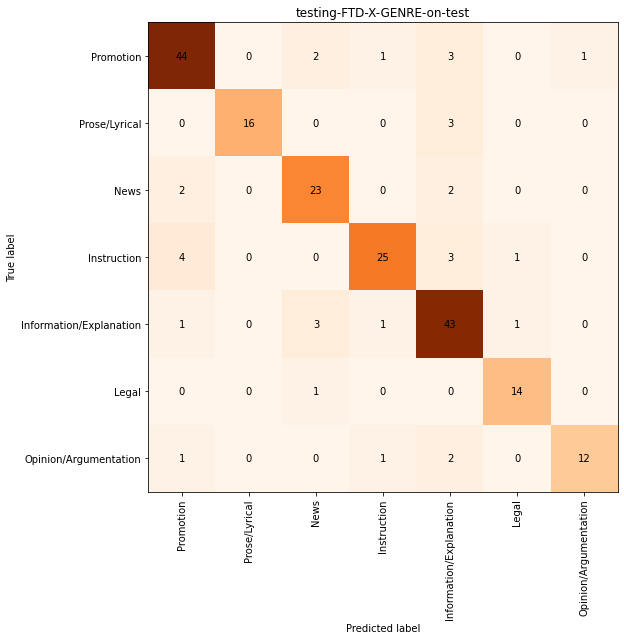


Testing finished.


<Figure size 432x288 with 0 Axes>

In [34]:
testing_FTD(test_df, "testing-FTD-X-GENRE-on-test", "FTD-test")
print("\nTesting finished.")

In [35]:
previous_results

,experiment,microF1,macroF1,y_true,y_pred,trained_on,tested_on
0,testing-FTD-X-GENRE-on-SL-GINCO-test,0.569832,0.498112,"{228: 'News', 12: 'Opinion/Argumentation', 617...","{228: 'Instruction', 12: 'Information/Explanat...",FTD,SL-GINCO
1,testing-FTD-X-GENRE-on-MT-GINCO-test,0.569832,0.457568,"{2: 'Promotion', 3: 'News', 12: 'Opinion/Argum...","{2: 'Promotion', 3: 'News', 12: 'Information/E...",FTD,MT-GINCO
2,testing-FTD-X-GENRE-on-CORE-test,0.477833,0.397299,"{216: 'Forum', 41678: 'Forum', 7171: 'News', 9...","{216: 'Opinion/Argumentation', 41678: 'Instruc...",FTD,CORE
3,testing-FTD-X-GENRE-on-dev,0.814286,0.827740,"{409: 'Instruction', 1051: 'Legal', 1473: 'Pro...","{409: 'Information/Explanation', 1051: 'Legal'...",FTD,FTD-dev
4,testing-FTD-X-GENRE-on-test,0.842857,0.851374,"{439: 'Promotion', 1576: 'Promotion', 913: 'Pr...","{439: 'Promotion', 1576: 'Promotion', 913: 'Pr...",FTD,FTD-test


In [37]:
# Save the file with results
previous_results.to_csv("/content/drive/MyDrive/GitHub/Genre-Datasets-Comparison/results/X-GENRE-Experiments-Results.csv", sep="\t")

## Applying the FTD classifier to the GINCO dataset

In [17]:
# Import the GINCO test split
sl_ginco_test = pd.read_csv("/content/drive/MyDrive/GitHub/Genre-Datasets-Comparison/data-splits/GINCO-SL-X-GENRE-test.csv", index_col = 0)

sl_ginco_test



,text,labels
228,Office Web Apps sedaj s podporo soavtorstvu <p...,News
12,"Bullshit detektor! <p/> Ekola, so mi rekli, na...",Opinion/Argumentation
617,Signature I za 1-2 osebi <p/> Vse savne Signat...,Promotion
276,spomini <p/> Spomini <p/> Po vojni smo živeli ...,Information/Explanation
473,V aprilu 2014 smo na račun tujih turistov zabe...,News
...,...,...
439,Bolonjska prenova <p/> Osrednji cilj Bolonjske...,Information/Explanation
516,Ojačevalec brezžičnega WiFi signala A9 je odli...,Promotion
645,Japonska – Kyoto in gejše <p/> Angleška pisate...,Opinion/Argumentation
451,ZDA Romunijo pozivajo k obrambi neodvisnega so...,News


Macro f1: 0.498, Micro f1: 0.57


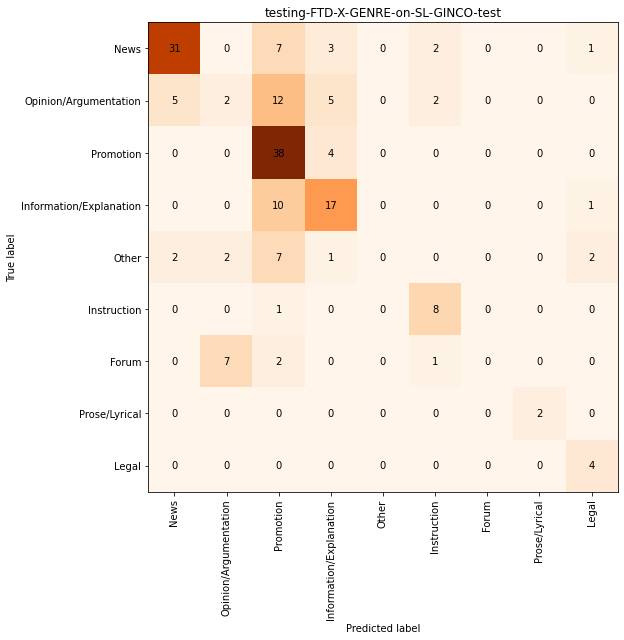


Testing finished.


<Figure size 432x288 with 0 Axes>

In [18]:
# Apply predictions
testing_FTD(sl_ginco_test, "testing-FTD-X-GENRE-on-SL-GINCO-test")

print("\nTesting finished.")

In [19]:
# Import MT-GINCO test file
mt_ginco_test = pd.read_csv("/content/drive/MyDrive/GitHub/Genre-Datasets-Comparison/data-splits/MT-GINCO-X-GENRE-test.csv", index_col = 0)

mt_ginco_test

,text,labels,split
2,Project INNOVAge and the Oreli Institute <p/> ...,Promotion,test
3,"In November, the month of addiction prevention...",News,test
12,"Bullshit detector! <p/> Ekola, they told me to...",Opinion/Argumentation,test
15,"Authorities, KS, Institutions, MI-SPO <p/> Win...",News,test
17,The saddest thing is that she has to defend he...,Forum,test
...,...,...,...
967,"The New Zealand Ministry of Transport, in conj...",News,test
978,Detached house for sale <p/> Primorje-Gorski K...,Promotion,test
980,I am making boils today and they are dark grey...,Other,test
992,What you need: a plastic bag and a freezer. <p...,Instruction,test


In [20]:
mt_ginco_test = mt_ginco_test.drop(columns=["split"])
mt_ginco_test

,text,labels
2,Project INNOVAge and the Oreli Institute <p/> ...,Promotion
3,"In November, the month of addiction prevention...",News
12,"Bullshit detector! <p/> Ekola, they told me to...",Opinion/Argumentation
15,"Authorities, KS, Institutions, MI-SPO <p/> Win...",News
17,The saddest thing is that she has to defend he...,Forum
...,...,...
967,"The New Zealand Ministry of Transport, in conj...",News
978,Detached house for sale <p/> Primorje-Gorski K...,Promotion
980,I am making boils today and they are dark grey...,Other
992,What you need: a plastic bag and a freezer. <p...,Instruction


Macro f1: 0.458, Micro f1: 0.57


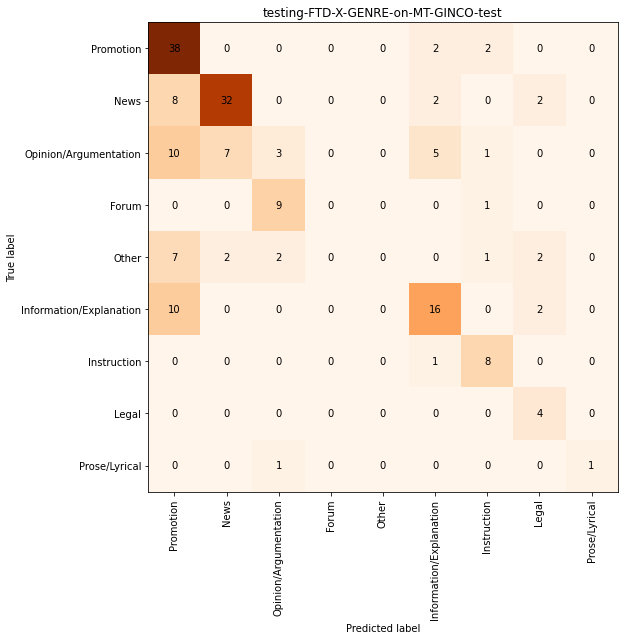


Testing finished.


<Figure size 432x288 with 0 Axes>

In [21]:
# Let's also apply the predictions to the MT GINCO set
testing_FTD(mt_ginco_test, "testing-FTD-X-GENRE-on-MT-GINCO-test")

print("\nTesting finished.")

In [23]:
# Compare the results by creating a dataframe from the previous_results dictionary:
results_df = pd.DataFrame(previous_results)

results_df

,experiment,num_train_epochs,train_batch_size,learning_rate,microF1,macroF1,y_true,y_pred
0,testing-FTD-X-GENRE-on-dev,8,8,0.00001,0.814286,0.827740,"{'409': 'Instruction', '1051': 'Legal', '1473'...","{'409': 'Information/Explanation', '1051': 'Le..."
1,testing-FTD-X-GENRE-on-test,8,8,0.00001,0.814286,0.827740,"{'409': 'Instruction', '1051': 'Legal', '1473'...","{'409': 'Information/Explanation', '1051': 'Le..."
2,testing-FTD-X-GENRE-on-SL-GINCO-test,8,8,0.00001,0.569832,0.498112,"{228: 'News', 12: 'Opinion/Argumentation', 617...","{228: 'Instruction', 12: 'Information/Explanat..."
3,testing-FTD-X-GENRE-on-MT-GINCO-test,8,8,0.00001,0.569832,0.457568,"{2: 'Promotion', 3: 'News', 12: 'Opinion/Argum...","{2: 'Promotion', 3: 'News', 12: 'Information/E..."


## Applying the FTD classifier to the CORE dataset

In [26]:
# Import CORE-X-GENRE test file
core_test = pd.read_csv("/content/drive/MyDrive/GitHub/Genre-Datasets-Comparison/data-splits/CORE-sample-X-GENRE-test.csv", index_col=0)

core_test

,text,labels
216,"grantarctic1 Never caught one Neels, but off t...",Forum
41678,Go back to Windows 7 or XP operating system If...,Forum
7171,Almost a quarter of Republicans think Obama 'm...,News
9960,Showcase Main menu You are here The Gatekeeper...,Prose/Lyrical
23790,It is the Time to Remember The unfulfilled Pro...,Opinion/Argumentation
...,...,...
4204,Emo broke into mainstream culture in the early...,Information/Explanation
31030,Terms & conditions Terms and Conditions The ma...,Legal
27580,The trust's 12th annual gala held at the Liber...,News
19104,Australia must find a Budget surplus before 20...,News


Macro f1: 0.397, Micro f1: 0.478


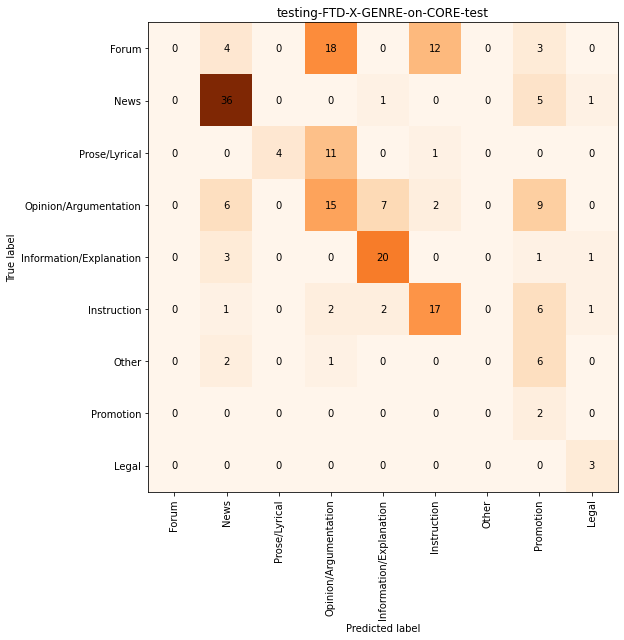


Testing finished.


<Figure size 432x288 with 0 Axes>

In [27]:
testing_FTD(core_test, "testing-FTD-X-GENRE-on-CORE-test")

print("\nTesting finished.")

In [28]:
# Compare the results by creating a dataframe from the previous_results dictionary:
results_df = pd.DataFrame(previous_results)

results_df

,experiment,num_train_epochs,train_batch_size,learning_rate,microF1,macroF1,y_true,y_pred
0,testing-FTD-X-GENRE-on-dev,8,8,0.00001,0.814286,0.827740,"{'409': 'Instruction', '1051': 'Legal', '1473'...","{'409': 'Information/Explanation', '1051': 'Le..."
1,testing-FTD-X-GENRE-on-test,8,8,0.00001,0.814286,0.827740,"{'409': 'Instruction', '1051': 'Legal', '1473'...","{'409': 'Information/Explanation', '1051': 'Le..."
2,testing-FTD-X-GENRE-on-SL-GINCO-test,8,8,0.00001,0.569832,0.498112,"{228: 'News', 12: 'Opinion/Argumentation', 617...","{228: 'Instruction', 12: 'Information/Explanat..."
3,testing-FTD-X-GENRE-on-MT-GINCO-test,8,8,0.00001,0.569832,0.457568,"{2: 'Promotion', 3: 'News', 12: 'Opinion/Argum...","{2: 'Promotion', 3: 'News', 12: 'Information/E..."
4,testing-FTD-X-GENRE-on-CORE-test,8,8,0.00001,0.477833,0.397299,"{216: 'Forum', 41678: 'Forum', 7171: 'News', 9...","{216: 'Opinion/Argumentation', 41678: 'Instruc..."


In [31]:
results_df["trained_on"] = "FTD"
results_df["tested_on"] = ["FTD-dev", "FTD", "SL-GINCO", "MT-GINCO", "CORE"]
results_df.drop(columns = ["num_train_epochs", "train_batch_size", "learning_rate"], inplace= True)

results_df

,experiment,microF1,macroF1,y_true,y_pred,trained_on,tested_on
0,testing-FTD-X-GENRE-on-dev,0.814286,0.827740,"{'409': 'Instruction', '1051': 'Legal', '1473'...","{'409': 'Information/Explanation', '1051': 'Le...",FTD,FTD-dev
1,testing-FTD-X-GENRE-on-test,0.814286,0.827740,"{'409': 'Instruction', '1051': 'Legal', '1473'...","{'409': 'Information/Explanation', '1051': 'Le...",FTD,FTD
2,testing-FTD-X-GENRE-on-SL-GINCO-test,0.569832,0.498112,"{228: 'News', 12: 'Opinion/Argumentation', 617...","{228: 'Instruction', 12: 'Information/Explanat...",FTD,SL-GINCO
3,testing-FTD-X-GENRE-on-MT-GINCO-test,0.569832,0.457568,"{2: 'Promotion', 3: 'News', 12: 'Opinion/Argum...","{2: 'Promotion', 3: 'News', 12: 'Information/E...",FTD,MT-GINCO
4,testing-FTD-X-GENRE-on-CORE-test,0.477833,0.397299,"{216: 'Forum', 41678: 'Forum', 7171: 'News', 9...","{216: 'Opinion/Argumentation', 41678: 'Instruc...",FTD,CORE


In [37]:
results_df.drop(index=0, inplace=True)
results_df

,experiment,microF1,macroF1,y_true,y_pred,trained_on,tested_on
1,testing-FTD-X-GENRE-on-test,0.814286,0.827740,"{'409': 'Instruction', '1051': 'Legal', '1473'...","{'409': 'Information/Explanation', '1051': 'Le...",FTD,FTD
2,testing-FTD-X-GENRE-on-SL-GINCO-test,0.569832,0.498112,"{228: 'News', 12: 'Opinion/Argumentation', 617...","{228: 'Instruction', 12: 'Information/Explanat...",FTD,SL-GINCO
3,testing-FTD-X-GENRE-on-MT-GINCO-test,0.569832,0.457568,"{2: 'Promotion', 3: 'News', 12: 'Opinion/Argum...","{2: 'Promotion', 3: 'News', 12: 'Information/E...",FTD,MT-GINCO
4,testing-FTD-X-GENRE-on-CORE-test,0.477833,0.397299,"{216: 'Forum', 41678: 'Forum', 7171: 'News', 9...","{216: 'Opinion/Argumentation', 41678: 'Instruc...",FTD,CORE


In [38]:
# Save the file with results
results_df.to_csv("/content/drive/MyDrive/GitHub/Genre-Datasets-Comparison/results/X-GENRE-Experiments-Results.csv", sep="\t")